<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/04_Transfer_learning_in_tensorflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Transer learning in tensorflow part 1 Feature Extraction

We've built a bunch of convolutional neural networks from scratch and they all them to be learning, however, there is still plenty of room for improvement.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned  from datasets such as [`ImageNet`](https://image-net.org/) (millions of images different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

## What we're going to cover

We're going to go through the following with TensorFlow:
- Introduce transfer learning 
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transer learning feature extraction model using Tensorflow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

## Using a GPU

To begin, let's check to see if we're using a GPU. Using a GPU will make sure our model trains faster than using just a CPU.


In [1]:
!nvidia-smi

Sun Aug 21 14:13:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-21 14:13:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   251MB/s    in 0.6s    

2022-08-21 14:13:04 (251 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each Folder? Inspect our data
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories ({dirnames}), {len(filenames)} images in '{dirpath}'")

There are 2 directories (['test', 'train']), 0 images in '10_food_classes_10_percent'
There are 10 directories (['steak', 'grilled_salmon', 'fried_rice', 'chicken_wings', 'sushi', 'hamburger', 'chicken_curry', 'pizza', 'ramen', 'ice_cream']), 0 images in '10_food_classes_10_percent/test'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/pizza'
There

In [4]:
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def visualize_image(targer_dir,target_class):
  """
  Visualize a random picture of a selected class from a target directory 
  
  Inputs:
  - target_dir : path of the target directory
  - target_class : name of the target class

  Return:
  - img : image
  """
  
  # target folder
  target_folder = f"{targer_dir}/{target_class}"

  for i in range(5):
    # take a random image inside the folder
    random_image = random.sample(os.listdir(target_folder),1)

    # plot the image
    img = mpimg.imread(f"{target_folder}/{random_image[0]}")
    print(f"Shape of the image: {img.shape}")
    plt.figure()
    plt.imshow(img)
    plt.show()

Shape of the image: (384, 512, 3)


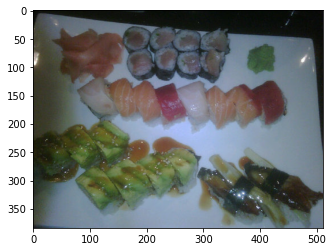

Shape of the image: (512, 512, 3)


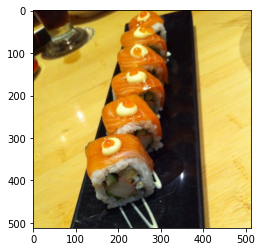

Shape of the image: (512, 512, 3)


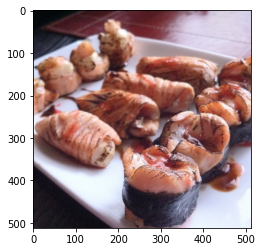

Shape of the image: (512, 289, 3)


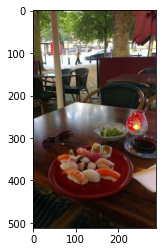

Shape of the image: (512, 512, 3)


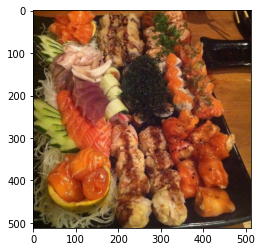

In [5]:
# Visualize random images
visualize_image("10_food_classes_10_percent/train","sushi")

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

## Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the `ImageDataGenerator` class along with the `flow_from_directory` method to load in our images.

In [6]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class)

## Setting up callbacks (things to run whilts our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks**.

[`Callbacks`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

- **[`Experiment tracking with TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)** - log the performance of multiple models and then view and compare these models in a visual war on **TensorBoard** (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on our data.
- **[`Model checkpointing`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)** - save your moel as it trains so you can stop training if needed and come back to continue off where you left. Helpful it training takes a long time and can't be done in one sitting.
- **[`Early stopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)** - leave your model training for an arbitrary amount of time and have it stop straining automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using `tf.keras.callbacks.TensorBoard()`.

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq=epoch` parameter. This is a good default since tracking model performance too often can slow down model training. 

To track our modelling experiments using TensorBoard, let's create a function wich creates a TensorBoard callback for us.

> **Note :** We create a function for creating a TensorBoard callback because as we'll see leter on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).

In [7]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  # path of the directory where to save the log files to be parsed by TensorBoard
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
  
  # tensorboard callback
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

  print(f"Saving TensorBoard log files to : {log_dir}")

  return tensorboard_callback

Because we're lickely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our functions saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:

- `dir_name` is the overall logs directory
- `experiment_name` is the particular experiment
- `current_timestamp` is the time the experiment started based on Python's `datetime.datetime().now()`.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [`TensorFlow Hub`](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:

1. [`ResNetV2`](https://arxiv.org/abs/1603.05027) - a state of the art computer vision model architecture from 2016.
2. [`EfficientNet`](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [`ImageNet (ILSVRC-2012-CLS)`](https://image-net.org/), the gold standard of computer vision benchmarks.

How do we find these models on TensorFLow Hub?

Here are the steps I took:

1. Go to [`TensorFlow Hub`](https://tfhub.dev/)
2. Choose your problem domain, e.g. "Image" (we're using food images)
3. Select the TF version, which in our case is TF2.
4. Remove all "Problem domain" filters except for the problem we're working on.
5. The models listed are all models which could potentially be used for our problem.

You can see a list of state of the art models on [`paperswithcode.com`](https://paperswithcode.com/), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since we're working with images, our target are the [`models wich perform best on ImageNet`](https://paperswithcode.com/sota/image-classification-on-imagenet)

You'll probably find not all of the model architectures listed on paperswithcode appear on TensorFlow Hub. And this is okay, we can still use what's available.

To find our models, let's narrow down our search using the Architecture tab.

1. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear.
- The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0.
  - However, the tradeoff with larger numbers can mean they take longer to compute.

2. Select EfficientNetB0 and you should see something like the following picture:

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png)

3. Clicking the one titled **"efficientnet/b0/feature-vector"** brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNEtB0.

- Copying the URL should give you something like this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

> **Question :** I thought we were doing image classification, why do we choose feature vector and not classification?

This is where the different types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.

- For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each) 

  - This is helpul if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpul if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `/classification` in their name on TensorFlow Hub provide this kind of functionality.

  2/ **"Feature extraction transfer learning"** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

  - For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 hase 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**.

    - This way all the underlying patterns remain in the rest of the layers and you can utilise thme for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **"Fine-tuning transfer learning"** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

- This is usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data.

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.

> 🤔 **Question:** Why train only the top 2-3 layers in feature extraction?

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)

In [8]:
# import tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Now we'll get the feature vector URLs of two common computer vision architectures, **EfficientNetB0 (2019)** and **ResNetV250 (2016)** from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.

In [9]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the `KerasLayer()` model inside the TensorFlow Hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instantiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [13]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):

  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it

  Arguments:
  - model_url (str): A TensorFlow Hub feature extraction URL.
  - num_classes (int): Number of output neurons in the output layer, 
                       should be equal to number of target classes, default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor layer
  and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

Once the model is instantiated, we'll compile it using `categorical_crossentropy` as our loss function, the Adam optimizer and accuracy as metric.

### Creating and testing ResNet TensorFlow Hub Feature extraction model

In [18]:
# Create Resnet model
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [20]:
# Compile the model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)

Time to fit the model.

We've got the training data ready in `train_data_10_percent` as well as the test data saved as `test_data`.

But before we call the fit function, there's one more thing we're going to add, a callback. More specifically, a TensorBoard callback so we can track the performance of our model on TensorBoard.

We can add a callback to our model by using the `callbacks` parameter in the fit function.

In our case, we'll pass the `callbacks` parameter in the `create_tensorboard_callback()` function we created earlier with some specific inputs so we know what experiments we're running.

In [34]:
# fit the model
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/2022-08-21_14:54:34
Epoch 1/5
24/24 [==============================] - 17s 701ms/step - loss: 0.3072 - accuracy: 0.9347 - val_loss: 0.6506 - val_accuracy: 0.7924
Epoch 2/5
24/24 [==============================] - 16s 692ms/step - loss: 0.2546 - accuracy: 0.9560 - val_loss: 0.6337 - val_accuracy: 0.7960
Epoch 3/5
24/24 [==============================] - 16s 695ms/step - loss: 0.2146 - accuracy: 0.9680 - val_loss: 0.6345 - val_accuracy: 0.7904
Epoch 4/5
24/24 [==============================] - 17s 715ms/step - loss: 0.1868 - accuracy: 0.9747 - val_loss: 0.6303 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 16s 695ms/step - loss: 0.1623 - accuracy: 0.9853 - val_loss: 0.6306 - val_accuracy: 0.7896


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving aroung 90% accuracy on the training set and nearly 80% accuracy on the test set... **with only 10 percent of the training images!**

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

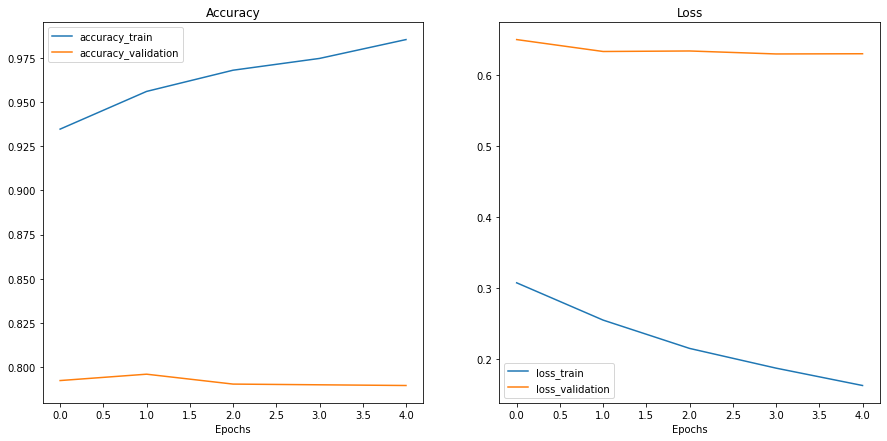

In [64]:
# pandas, matplotlib libraries
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """

  """
  # accuracy
  acc_train = history.history["accuracy"]
  acc_val = history.history["val_accuracy"]

  # loss
  loss_train = history.history["loss"]
  loss_val = history.history["val_loss"]

  # figure
  fig, axs = plt.subplots(1,2,figsize=(15,7))

  # plot accuracy
  axs[0].plot(acc_train, label="accuracy_train")
  axs[0].plot(acc_val, label="accuracy_validation")
  axs[0].legend()
  axs[0].set_xlabel("Epochs")
  axs[0].set_title("Accuracy")

  # plot losses
  axs[1].plot(loss_train, label="loss_train")
  axs[1].plot(loss_val, label="loss_validation")
  axs[1].legend()
  axs[1].set_xlabel("Epochs")
  axs[1].set_title("Loss")


plot_loss_curves(history_resnet)